In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [6]:
data = pd.read_csv('../Dataset/fake_or_real_news.csv').dropna()
data = data.drop(columns=['Unnamed: 0'])
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


# 3. Initial Analysis

### 3.1. Metadata

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [8]:
data['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [9]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

[Text(0, 0, '3164'), Text(0, 0, '3171')]

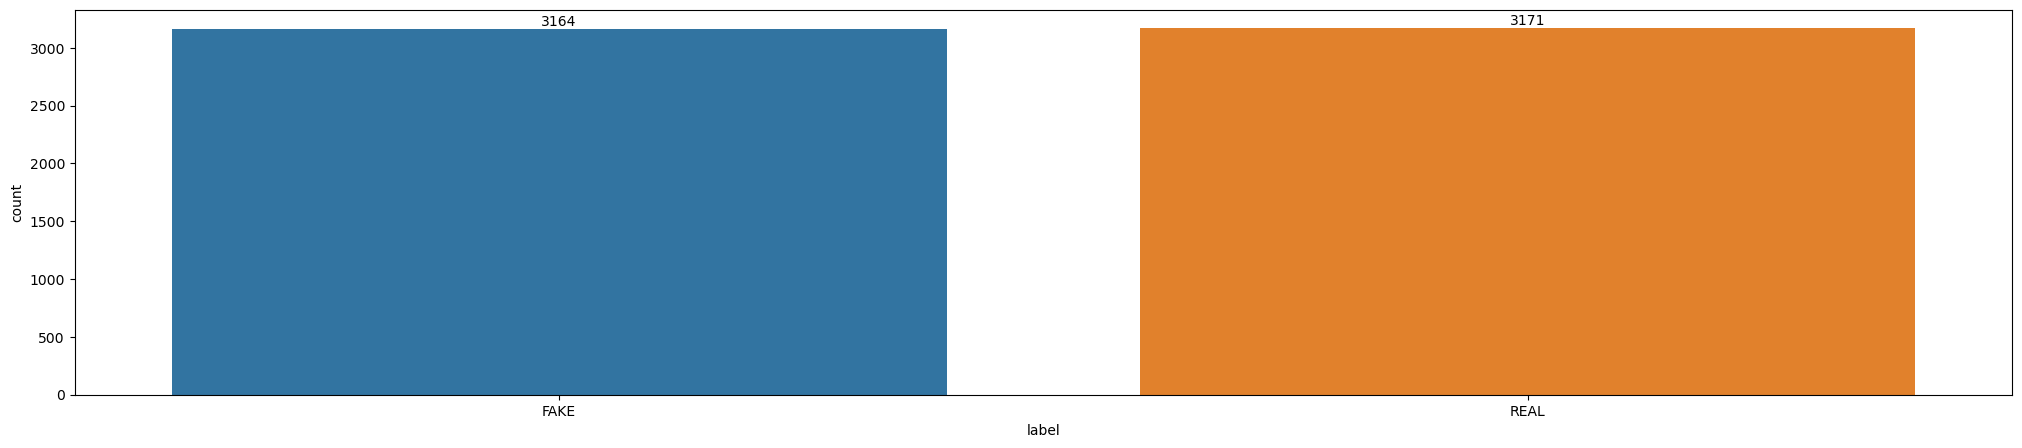

In [10]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['label'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [12]:
data['combined_text'] = data['title'] + ' ' + data['text']
data

,title,text,label,combined_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...
...,...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,State Department says it can't find emails fro...
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,Anti-Trump Protesters Are Tools of the Oligarc...
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,"In Ethiopia, Obama seeks progress on peace, se..."


In [15]:
stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s.,]', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    return " ".join(text)
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # convert to lower case and tokenize
    words = [word for word in words if word.isalnum()]  # filter out non-alphanumeric characters
    words = [lemmatize_word(word) for word in words]  # lemmatize each word
    return ' '.join(words)  # join the lemmatized words back into a sentence




In [17]:
data['clean_text'] = data['combined_text'] \
                    .progress_apply(clean) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/6335 [00:00<?, ?it/s]

  0%|          | 0/6335 [00:00<?, ?it/s]

,title,text,label,combined_text,clean_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillarys fear daniel greenfield shillman...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy us secretary s...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporters twitter erupt anger dnc try ...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...


<Axes: xlabel='text_len'>

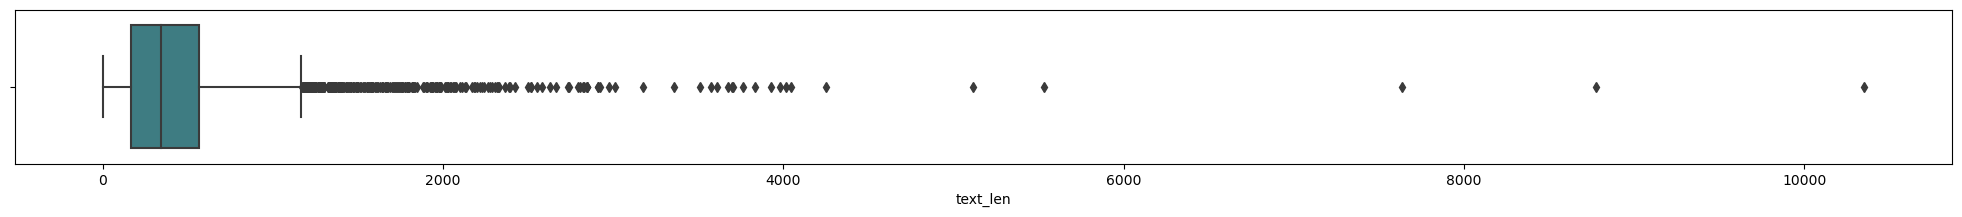

In [18]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [21]:
print(data['text_len'].quantile(0.1))
print(data['text_len'].quantile(.75))

59.0
569.0


<Axes: xlabel='text_len'>

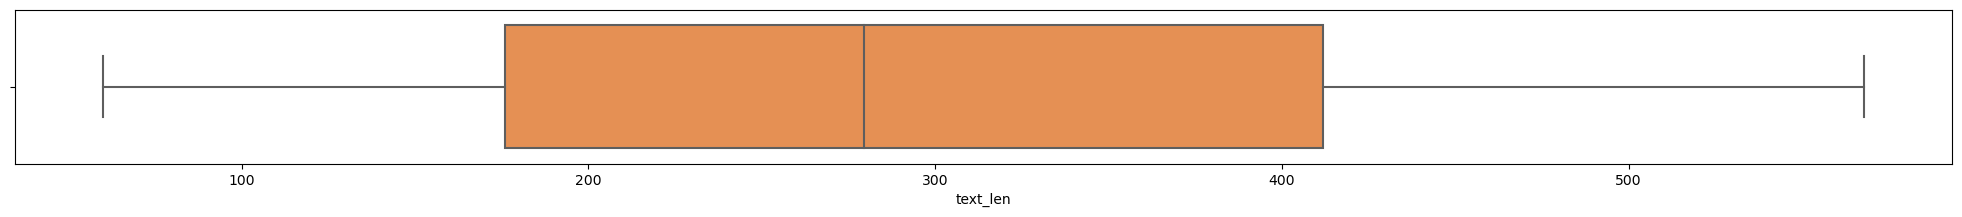

In [22]:
Q1 = data['text_len'].quantile(0.1)
Q3 = data['text_len'].quantile(.75)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

[Text(0, 0, '2218'), Text(0, 0, '1896')]

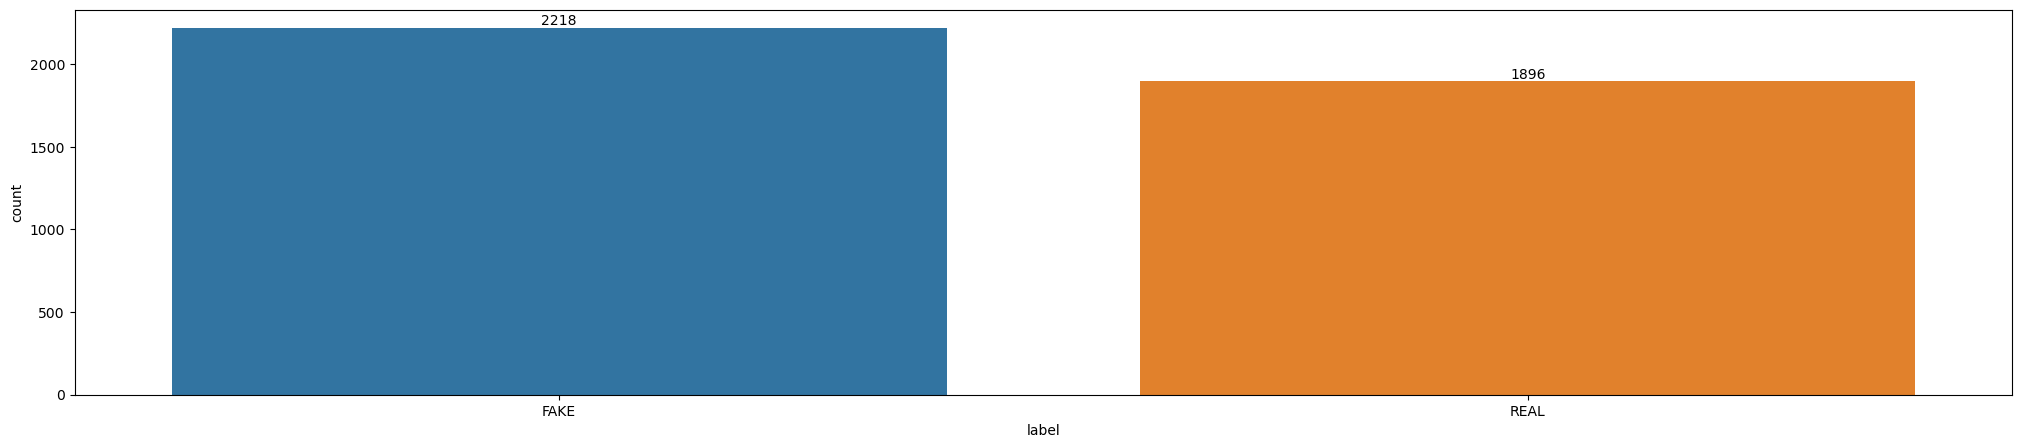

In [23]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['label'])
ax.bar_label(ax.containers[0])

# 4. Preparing Dataset

In [52]:
LE = LabelEncoder()

X = data['clean_text']
Y = LE.fit_transform(data['label']) ### For Classification Algoritms
# Y = pd.get_dummies(data['label']) ### For Deep Learning Algoritms
# Y = data['label'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2887,)
(815,)
(412,)


In [53]:
vocab_size = 20_000
embedding_dim = 256
max_length = 570
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [54]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

66669


In [29]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

print(training_padded.shape)
print(testing_padded.shape)
print(validating_padded.shape)


66669
(2652, 570)
(738, 570)
(402, 570)


# 5. Deep Learning Model

In [36]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(2, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 570, 256)          5120000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 570, 512)         789504    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 7,093,250
Trainable params: 7,093,250
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epoch = 10
batch_size = 32
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/10
91/91 [==============================] - 29s 259ms/step - loss: 0.4339 - accuracy: 0.8105 - val_loss: 0.2878 - val_accuracy: 0.8956
Epoch 2/10
91/91 [==============================] - 22s 244ms/step - loss: 0.0620 - accuracy: 0.9816 - val_loss: 0.3506 - val_accuracy: 0.8883
Epoch 3/10
91/91 [==============================] - 23s 249ms/step - loss: 0.0144 - accuracy: 0.9952 - val_loss: 0.4286 - val_accuracy: 0.8932
Epoch 4/10
91/91 [==============================] - 22s 246ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.4555 - val_accuracy: 0.9175
Epoch 5/10
91/91 [==============================] - 23s 249ms/step - loss: 9.5611e-04 - accuracy: 0.9997 - val_loss: 0.4903 - val_accuracy: 0.9102
Epoch 6/10
91/91 [==============================] - 22s 242ms/step - loss: 9.1439e-05 - accuracy: 1.0000 - val_loss: 0.5380 - val_accuracy: 0.9126
Epoch 7/10
91/91 [==============================] - 22s 244ms/step - loss: 2.9166e-05 - accuracy: 1.0000 - val_loss: 0.5605 - val_accu

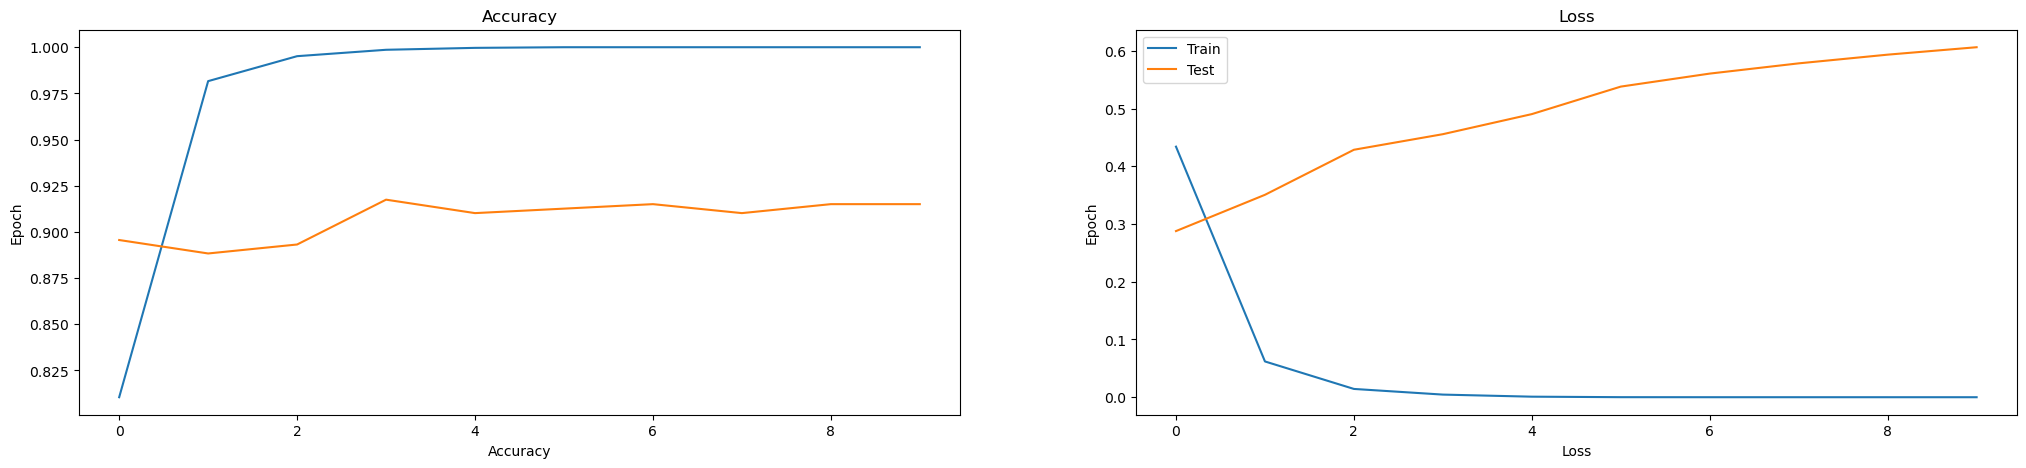

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [39]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        1     0
1                  0        0     0
2                  0        0     0
3                  0        0     0
4                  1        1     0
97 / 815


In [40]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       446
           1       0.88      0.85      0.87       369

    accuracy                           0.88       815
   macro avg       0.88      0.88      0.88       815
weighted avg       0.88      0.88      0.88       815



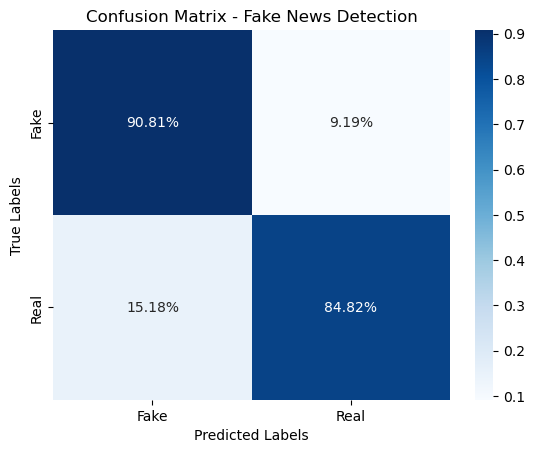

In [42]:
labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [55]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    ('XGB', XGB),
    # ('randomforest', randomForest),
    # ('histGradientBoosting', histGradientBoosting),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTres', extraTrees),
    # ('knn', knn),
    # ('decisionTree', decisionTree),
    # ('gradient', gradient),

], n_jobs=-1)

In [56]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [57]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 72.52 %
R Squared Error    : -0.11
Mean Squared Error : 0.27


In [58]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        1     0
1                  0        0     0
2                  0        0     0
3                  0        0     0
4                  1        1     0
224 / 815


In [59]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       446
           1       0.70      0.70      0.70       369

    accuracy                           0.73       815
   macro avg       0.72      0.72      0.72       815
weighted avg       0.73      0.73      0.73       815



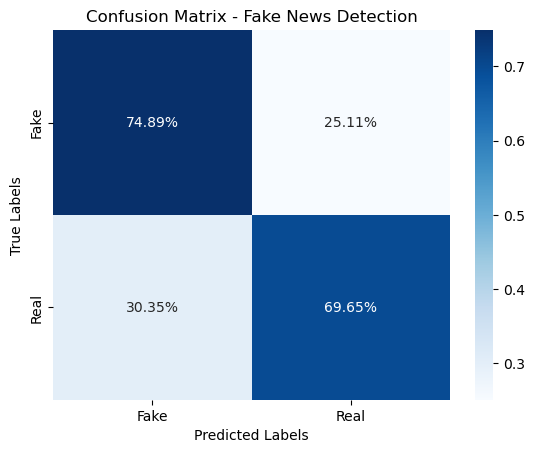

In [60]:
labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()